## Read in the appropriate packages 

In [1]:
!pip install pmdarima

You should consider upgrading via the 'c:\users\frede\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
from pandas_datareader import data as pdr #read data from yahoo finance api
import matplotlib.pyplot as plt #viz #GUI manager
import seaborn as sns #viz #plotly is another package
import datetime 
import pandas as pd
import numpy as np
from pandas import Grouper #groupby
#statistical data exploration, conducting statistical tests, and estimation of different statistical models
import statsmodels.api as sm 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #autocorrelation plot
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing
from pandas.plotting import autocorrelation_plot #autocorrelation plot
from statsmodels.graphics.gofplots import qqplot #residual diagnostics
from sklearn.metrics import mean_squared_error #accuracy metrics
from math import sqrt
from sklearn.metrics import mean_absolute_error #accuracy metrics

from random import gauss #create gaussian white noise
from random import seed
from pandas import Series 

from statsmodels.tsa.stattools import adfuller # Augmented Dickey Fuller test for testing stationarity

from statsmodels.tsa.arima.model import ARIMA #for manual ARIMA

import pmdarima as pm #auto arima


## 1. Read in the monthly anti-diabetic drug sales in Australia dataset

Download the data from the the gdrive: https://drive.google.com/file/d/1LtTyAaWTCWYwjWG9OdSo_gUoRg5579Mk/view?usp=sharing

In [3]:
# Downloading SINGLE stock using pandas_datareader

drug_sales_df = pd.read_csv('drug_sales_australia.csv',
                             parse_dates=['date'],
                             index_col=['date'])
drug_sales_df

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869
...,...
2008-02-01,21.654285
2008-03-01,18.264945
2008-04-01,23.107677


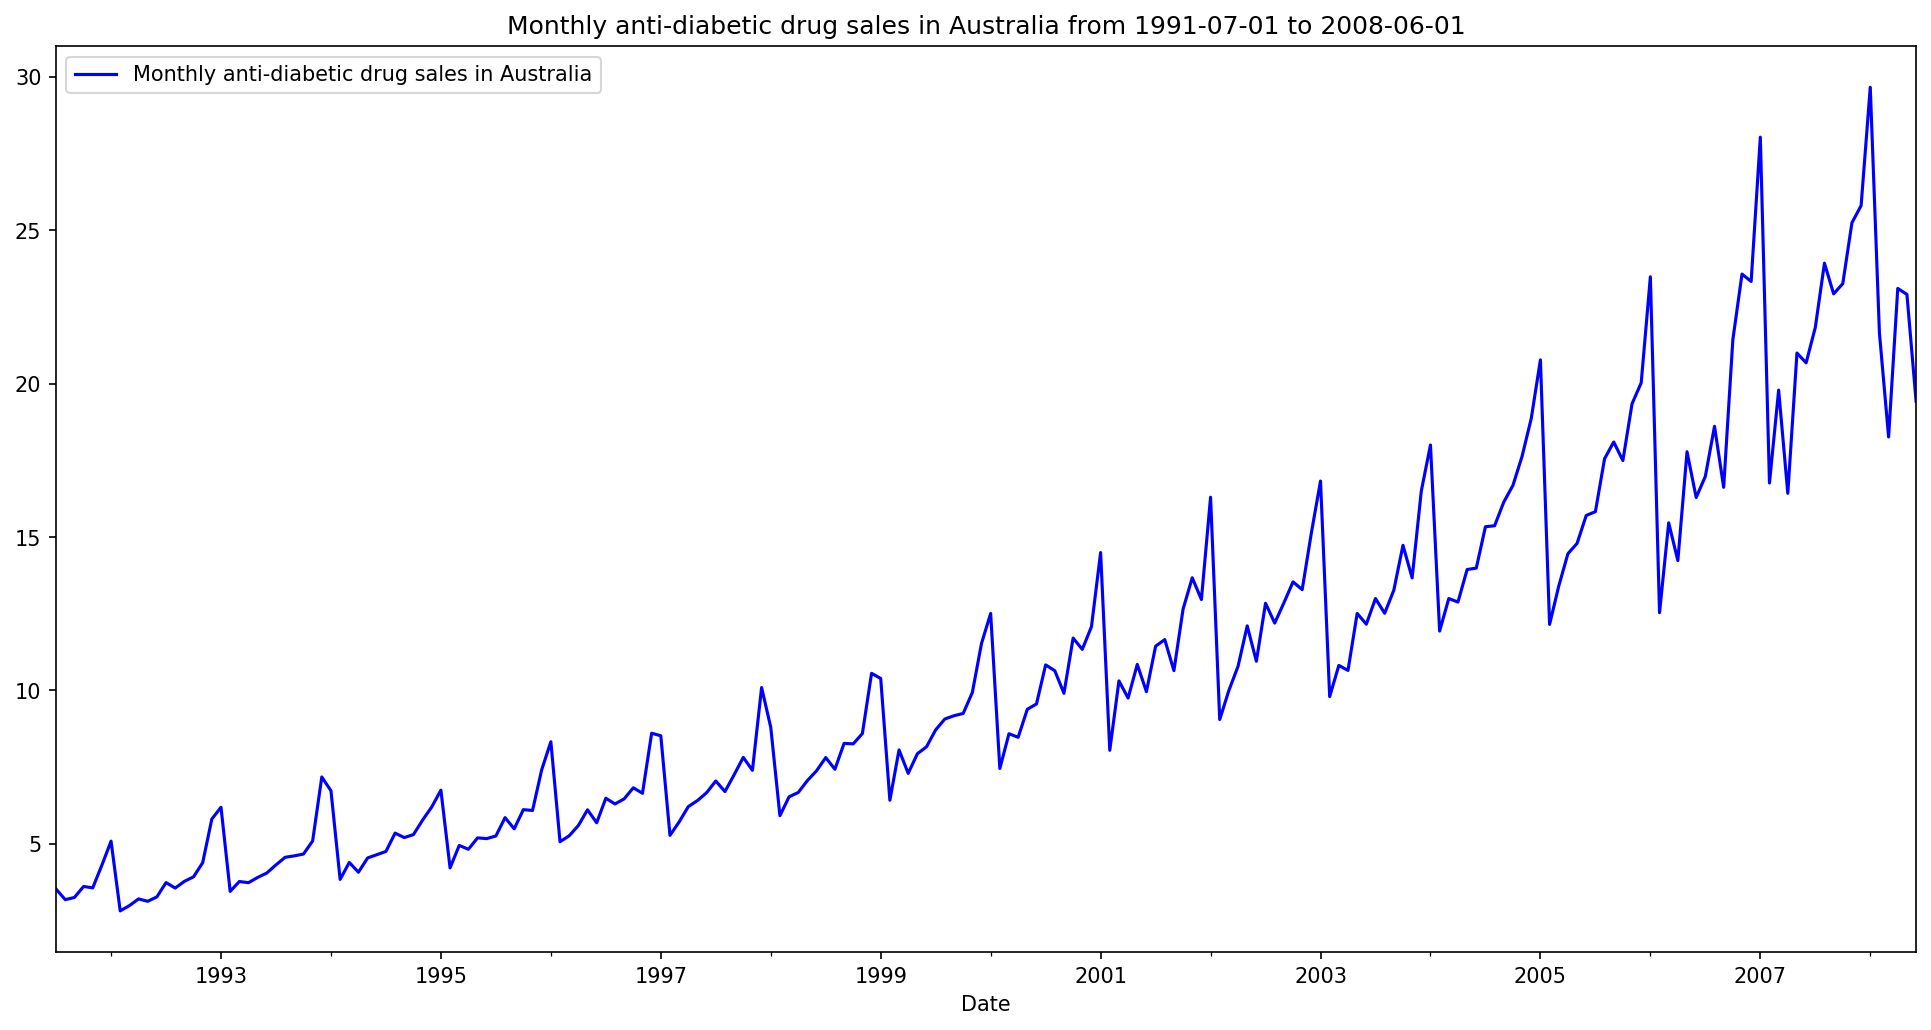

In [4]:
# Visualizing the series
  
# to set the plot size
plt.figure(figsize=(16, 8), dpi=150) #dpi = resolution. default 100.
  
# in plot method we set the label and color of the curve.
drug_sales_df['value'].plot(label='Monthly anti-diabetic drug sales in Australia', color='blue')
  
# adding title to the plot
plt.title('Monthly anti-diabetic drug sales in Australia from {} to {}'.format('1991-07-01', '2008-06-01'))
  
# adding Label to the x-axis
plt.xlabel('Date')
  
# adding legend to the curve
plt.legend()


In [5]:
#questions
#1. trend or seasonality?   Trend
#2. additive or multiplicative trend and seasonality?   seems like multiplicative trend and seasonality

### From the above chart, both trend and seasonality exist; and it is multiplicative trend and seasonality.

In [6]:
drug_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 204 entries, 1991-07-01 to 2008-06-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   204 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


## 2. Exploratory Data Analysis (EDA)


In [7]:
# 1. Descriptive Statistics
drug_sales_df.describe()

,value
count,204.000000
mean,10.694430
std,5.956998
min,2.814520
25%,5.844095
50%,9.319345
75%,14.289964
max,29.665356


<AxesSubplot:>

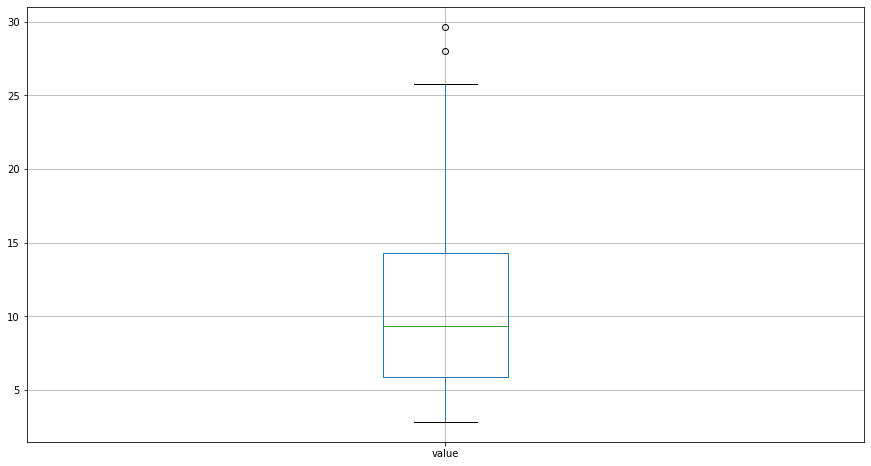

In [8]:
plt.figure(figsize=(15,8))
drug_sales_df.boxplot()

### The data is right skewed, with some outliers. 

In [9]:
# 2. Check for missing values
drug_sales_df.isnull().sum()

value    0
dtype: int64

In [10]:
# 3. Find the indexes that are missing
pd.date_range(start = drug_sales_df.index.min(), end = drug_sales_df.index.max(), freq='MS').difference(drug_sales_df.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

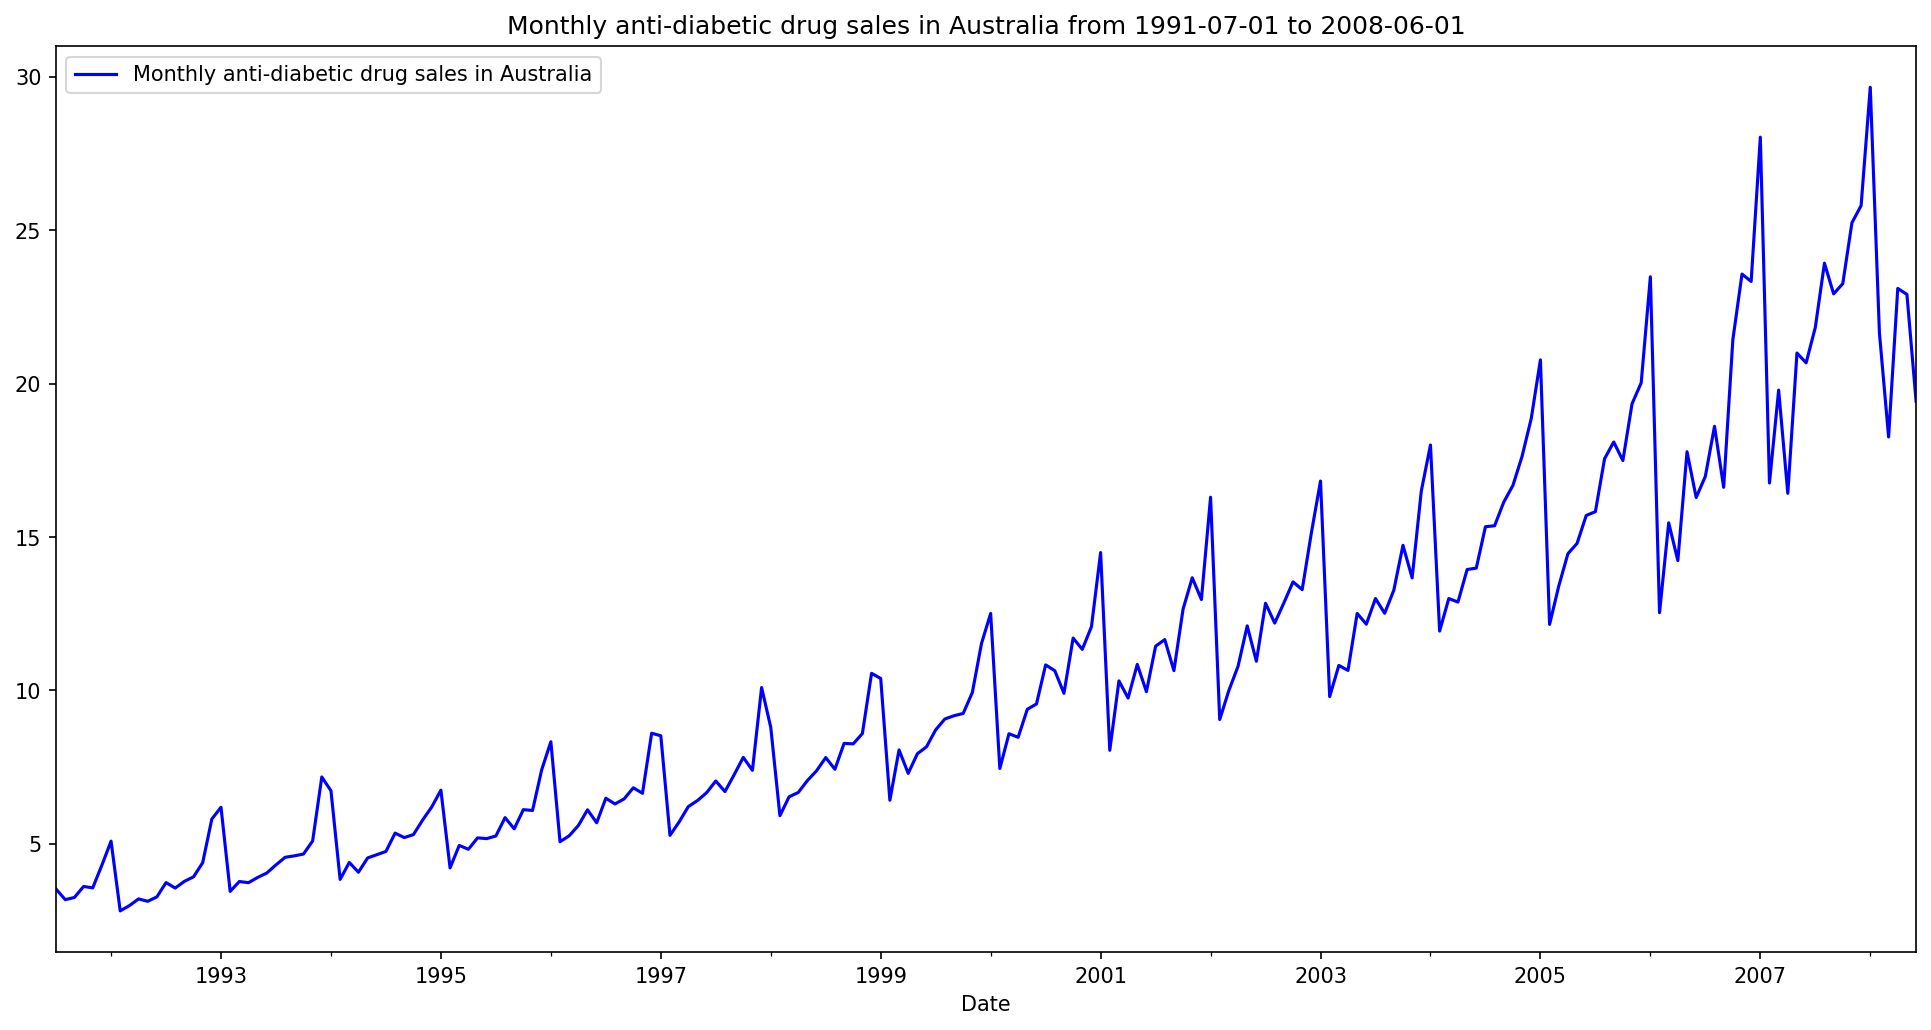

In [11]:
# Visualizing the series
  
# to set the plot size
plt.figure(figsize=(16, 8), dpi=150) #dpi = resolution. default 100.
  
# in plot method we set the label and color of the curve.
drug_sales_df['value'].plot(label='Monthly anti-diabetic drug sales in Australia', color='blue')
  
# adding title to the plot
plt.title('Monthly anti-diabetic drug sales in Australia from {} to {}'.format('1991-07-01', '2008-06-01'))
  
# adding Label to the x-axis
plt.xlabel('Date')
  
# adding legend to the curve
plt.legend()


## Stationarity  

### Why Does Stationarity Matter in Time Series Analysis? Why do we have to make sure our data set is stationary before we can run different ARIMA models on it? 


1. Consider the forecasting problem. How do you forecast? If everything's different tomorrow then it's impossible to forecast, because everything's going to be different. So the key to forecasting is to find something that will be the same tomorrow, and extend that to tomorrow. Hence, a stationarized series is relatively easy to predict. 

2. Statistical modeling methods assume or require the time series to be stationary to be effective. The ARIMA models predict that the mean and variance will be the same in the future as they have been in the past. A stationary time series will also allow us to obtain meaningful statistics such as means, variances, and correlations with other variables. These stats are only useful descriptors if the series is stationary.

3. As in the case of the monthly anti-diabetic drug sales, the series is consistently increasing over time. Hence, the sample mean and variance will grow with the size of the sample and the models will always underestimate the mean and variance in the future periods. 

Ssource: https://towardsdatascience.com/why-does-stationarity-matter-in-time-series-analysis-e2fb7be74454

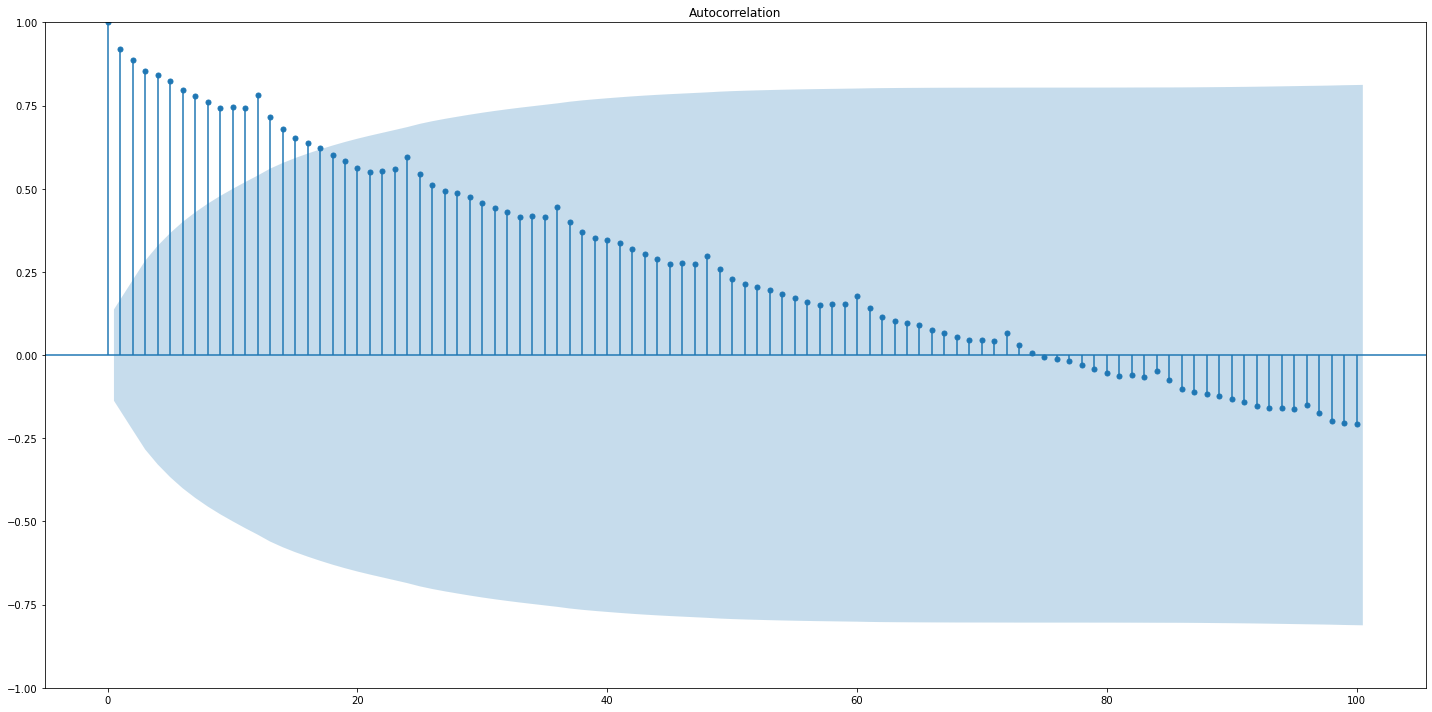

In [12]:
#check if the data is stationary

# autocorrelation plot of the dataset
fig = plot_acf(drug_sales_df, lags=100)
fig.set_size_inches((20, 10))
# Tight layout to realign things
fig.tight_layout()
plt.show()

In [13]:
df = pd.DataFrame({'value' : [76,93,82,95,93,97,72,105,83,92,88,87]}, index =['1990 Jan','1990 Jun','1991 Jan','1991 Jun','1992 Jan','1992 Jun','1993 Jan','1993 Jun','1994 Jan','1994 Jun','1995 Jan','1995 Jun'] )

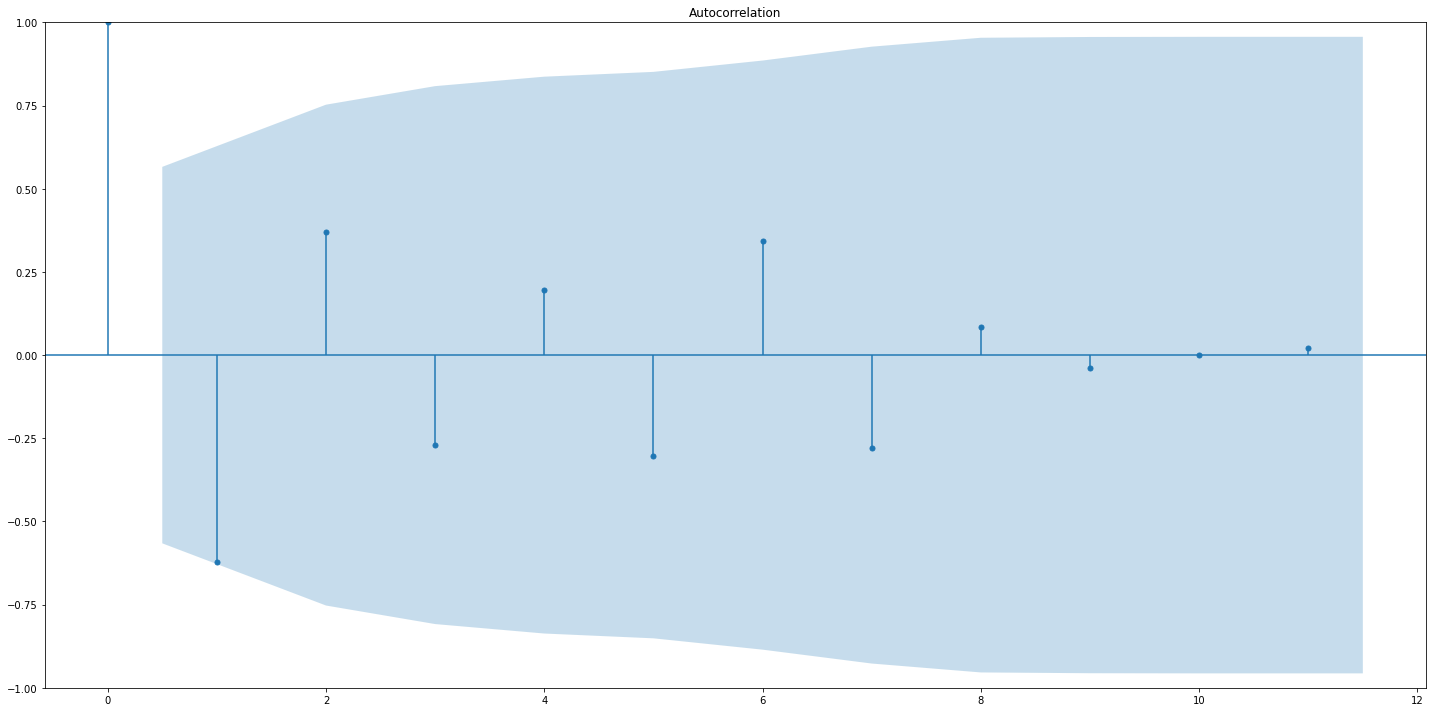

In [14]:
fig = plot_acf(df, lags=11)
fig.set_size_inches((20, 10))
# Tight layout to realign things
fig.tight_layout()
plt.show()

In [15]:
y = df.values
result = adfuller(y)
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.433757
p-value: 0.000000
Critical Values:
	1%: -4.223
	5%: -3.189
	10%: -2.730


### since p-value < 0.05, the data does not have a unit root and is stationary. 

In [16]:
#data has trend as well as seasonlity of 12 months

## Unit Root Test - Augmented Dickey-Fuller (ADF) test to check stationarity 

In [17]:
X = drug_sales_df.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 3.145186
p-value: 1.000000
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575


Running the test prints the test statistic value of 3.14. The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset). As part of the output, we get a look-up table to help determine the ADF statistic. We can see that our statistic value of 3.14 is greater than the value of -2.87 at 5%. Also, the p-value is greater than 0.05.

This suggests that we fail to reject the null hypothesis with a significance level of 5%. Failing to reject the null hypothesis means that the process a unit root, and in turn that the time series is non-stationary.

## Differencing 

One of the best ways to make a non-stationary time series stationary — compute the differences between consecutive observations. This is known as differencing.

Transformations such as logarithms can help to stabilise the variance of a time series. Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality.

<AxesSubplot:xlabel='date'>

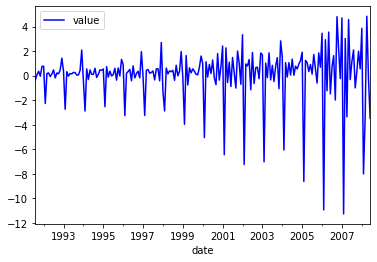

In [18]:
#create differenced dataset
first_diff_df = drug_sales_df.diff().dropna()
first_diff_df.plot(color='blue')

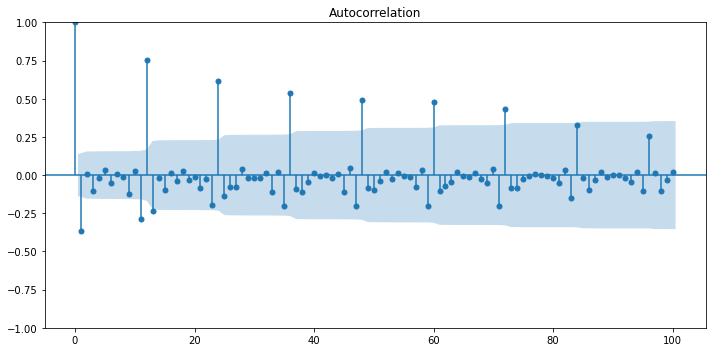

In [19]:
# autocorrelation plot of differenced dataset
fig = plot_acf(first_diff_df, lags=100)
fig.set_size_inches((10, 5))
# Tight layout to realign things
fig.tight_layout()
plt.show()

In [20]:
X = first_diff_df.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.495172
p-value: 0.116653
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575


From the ACF and line plot and the ADF test p-value we can deduce that the series is non-stationary. As we can see a seasonal pattern, let us apply seasonal differencing. 

<AxesSubplot:xlabel='date'>

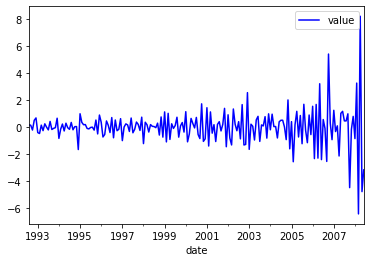

In [21]:
seasonal_diff_df = first_diff_df.diff(12).dropna()    # 2nd differencing
seasonal_diff_df.plot(color = 'blue')

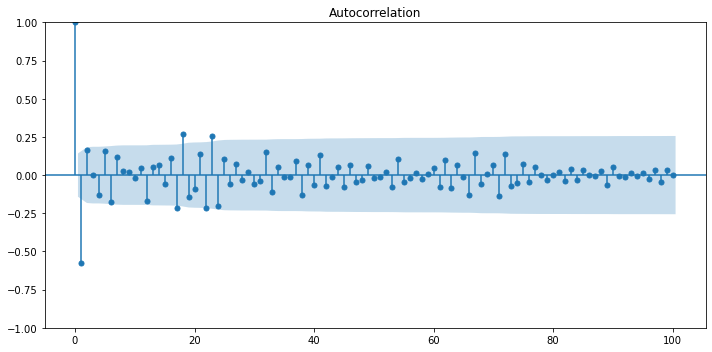

In [22]:
# autocorrelation plot of the seasonaly differenced dataset
fig = plot_acf(seasonal_diff_df, lags=100)
fig.set_size_inches((10, 5))
# Tight layout to realign things
fig.tight_layout()
plt.show()

In [23]:
X = seasonal_diff_df.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.783440
p-value: 0.000058
Critical Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576


Since p-value is less than 0.05 we can reject the null hypothesis and the data is stationary.

## Seasonal differencing and interpretation of differencing

When both seasonal and first differences are applied -
1. it makes no difference which is done first—the result will be the same.
2. If seasonality is strong, it is recommended that seasonal differencing be done first because sometimes the resulting series will be stationary and there will be no need for further first difference.

Also, it is important that if differencing is used, the differences are interpretable.
1. first differences are the change between one observation and the next.
2. seasonal differences are the change between one year to the next.

But taking lag 3 differences for yearly data, for example, results in a model which cannot be sensibly interpreted.


## Time to test out the forecasts - split data into train and test sets

In [24]:
drug_sales_df

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869
...,...
2008-02-01,21.654285
2008-03-01,18.264945
2008-04-01,23.107677


In [25]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(drug_sales_df, test_size=12, random_state=25, shuffle = False)
#shuffle = False is very important to ensure the order of the data

print(f"No. of training examples: {train_data.shape[0]}")
print(f"No. of testing examples: {test_data.shape[0]}")

No. of training examples: 192
No. of testing examples: 12


In [26]:
train_data

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869
...,...
2007-02-01,16.763869
2007-03-01,19.792754
2007-04-01,16.427305


In [27]:
test_data

,value
date,
2007-07-01,21.834890
2007-08-01,23.930204
2007-09-01,22.930357
2007-10-01,23.263340
2007-11-01,25.250030
2007-12-01,25.806090
2008-01-01,29.665356
2008-02-01,21.654285
2008-03-01,18.264945


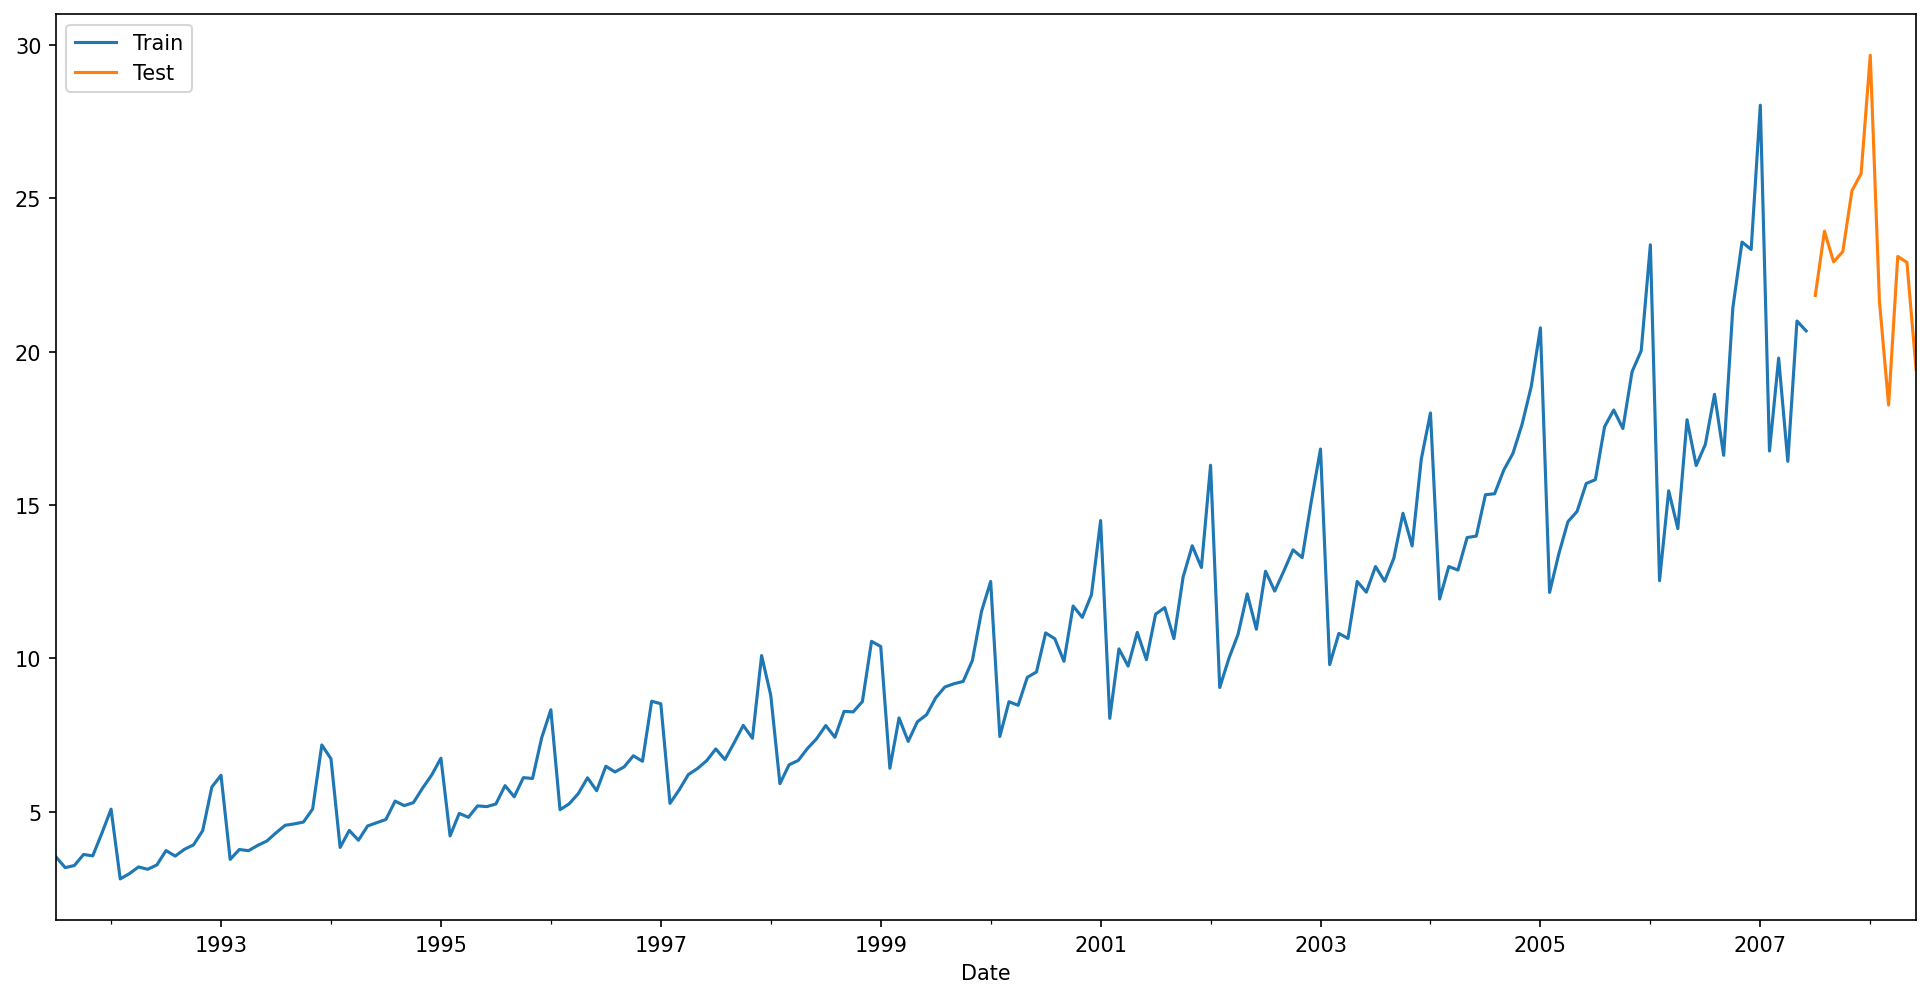

In [28]:
#Plot train and test data

# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)
  
# using plot method to plot close prices.
# in plot method we set the label and color of the curve.
train_data['value'].plot(label='Train')
test_data['value'].plot(label='Test')
  
# adding Label to the x-axis
plt.xlabel('Date')
  
# adding legend to the curve
plt.legend()


## Fitting Models - AR, MA, non-seasonal, and seasonal ARIMA Models

In [29]:
# Refer slides

ARIMA models cater to a suite of standard structures in time series data, and as such provide a simple yet powerful method for making skillful time series forecasts.

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average.

1. AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
2. I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
3. MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:

p: The number of lag observations included in the model, also called the lag order.
d: The number of times that the raw observations are differenced, also called the degree of differencing.
q: The size of the moving average window, also called the order of moving average.

A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model.

A value of 0 can be used for a parameter, which indicates to not use that element of the model. This way, the ARIMA model can be configured to perform the function of an ARMA model, and even a simple AR, I, or MA model.

Source: 
1. https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

### How to find the order of the AR (p) and MA (q) term?

You can find out the required number of AR and MA terms by inspecting the Autocorrelation (ACF) and Partial Autocorrelation (PACF) plot of the differenced time series.

What is Partial Autocorrelation?

Recall that an ACF plot shows the autocorrelations which measure the relationship between lagged values of a time series. Now if yt and yt−1 are correlated, then yt−1 and yt-2 must also be correlated. However, then yt and yt-2 might be correlated, simply because they are both connected to yt-1, rather than because of any new information contained in yt-2 that could be used in forecasting yt.

To overcome this problem, we can use partial autocorrelations. These measure the relationship between yt and  yt-k after removing the effects of lags 1,2,3,...,k-1.

ACF and PACF plots of the differenced time series helps us determine if we should use AR, MA, or both components. Generally, either AR or MA terms are used. Models that use both are less common. 

ACF plot
1. If the stationarized time series has positive autocorrealtion at lag 1, AR terms are best. If it has negative autocorrealtion at lag 1, MA terms are best.
2. Decay and cut off of the ACF gives us hints at what terms to use.

PACF plot
1. If the partial autocorrelation abruptly drops off at lag k, it indicates an AR model.
2. If it drops off gradually, it suggests an MA model.


In [30]:
# AR or MA?

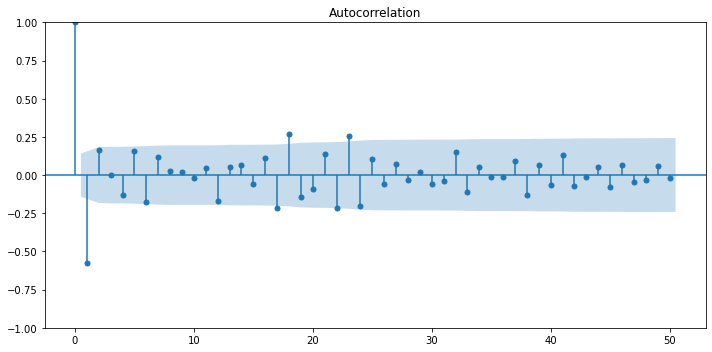

In [31]:
# autocorrelation plot of the seasonaly differenced dataset
fig = plot_acf(seasonal_diff_df, lags=50)
fig.set_size_inches((10, 5))
# Tight layout to realign things
fig.tight_layout()
plt.show()

### MA model, because lag 1 is negative autocorrelation. And the cut off point shows p = 1 is good

C:\Users\frede\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


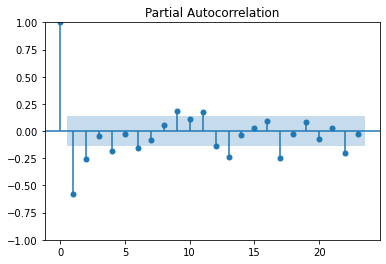

In [32]:
#plot PACF of the differenced time series.
plot_pacf(seasonal_diff_df)
plt.show()

### AR or MA?   AR model

### Build ARIMA manually

In [35]:
drug_sales_df1 = drug_sales_df.loc[:'2005-06-01']
drug_sales_df2 = drug_sales_df.loc[:'2006-06-01']
drug_sales_df3 = drug_sales_df.loc[:'2007-06-01']
drug_sales_df4 = drug_sales_df.loc[:'2008-06-01']

train_data1, test_data1 = train_test_split(drug_sales_df1, test_size=12, random_state=25, shuffle = False)
train_data2, test_data2 = train_test_split(drug_sales_df2, test_size=12, random_state=25, shuffle = False)
train_data3, test_data3 = train_test_split(drug_sales_df3, test_size=12, random_state=25, shuffle = False)
train_data4, test_data4 = train_test_split(drug_sales_df4, test_size=12, random_state=25, shuffle = False)

In [36]:
# p,d,q = 0,2,1 ARIMA Model
manual_model1 = ARIMA(train_data1, order=(1,1,1))
manual_model_fit1 = manual_model1.fit()
print(manual_model_fit1.summary())

manual_model2 = ARIMA(train_data2, order=(1,1,1))
manual_model_fit2 = manual_model2.fit()
#print(manual_model_fit1.summary())

manual_model3 = ARIMA(train_data3, order=(1,1,1))
manual_model_fit3 = manual_model3.fit()
#print(manual_model_fit1.summary())

manual_model4 = ARIMA(train_data4, order=(1,1,1))
manual_model_fit4 = manual_model4.fit()
#print(manual_model_fit1.summary())



C:\Users\frede\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\frede\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\frede\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  156
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -271.378
Date:                Thu, 17 Nov 2022   AIC                            548.757
Time:                        11:44:45   BIC                            557.887
Sample:                    07-01-1991   HQIC                           552.465
                         - 06-01-2004                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2838      0.176      1.613      0.107      -0.061       0.629
ma.L1         -0.8428      0.088     -9.542      0.000      -1.016      -0.670
sigma2         1.9324      0.173     11.170      0.0

C:\Users\frede\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\frede\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\frede\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\frede\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\frede\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

In [37]:
# manual arima forecast

# Forecast
fc1 = manual_model_fit1.forecast(12)  # 95% conf
fc2 = manual_model_fit2.forecast(12)
fc3 = manual_model_fit3.forecast(12)
fc4 = manual_model_fit4.forecast(12)

In [38]:
# Make as pandas series

fc_series1 = pd.Series(fc1, index=test_data1.index)
fc_series2 = pd.Series(fc2, index=test_data2.index)
fc_series3 = pd.Series(fc3, index=test_data3.index)
fc_series4 = pd.Series(fc4, index=test_data4.index)
# lower_series = pd.Series(conf[:, 0], index=test_data.index)
# upper_series = pd.Series(conf[:, 1], index=test_data.index)


In [ ]:
# Plot
# plt.figure(figsize=(12,5), dpi=100)
# plt.plot(train_data, label='training')
# plt.plot(test_data, label='test')
# plt.plot(fc_series, label='forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.15)
# plt.title('Forecast vs Actuals')
# plt.legend(loc='upper left', fontsize=8)
# plt.show()

## Auto ARIMA - Non seasonal

auto_arima() uses a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC.

In [40]:
drug_sales_df4

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869
...,...
2008-02-01,21.654285
2008-03-01,18.264945
2008-04-01,23.107677


In [41]:

test_data1

,value
date,
2004-07-01,15.339097
2004-08-01,15.370764
2004-09-01,16.142005
2004-10-01,16.685754
2004-11-01,17.636728
2004-12-01,18.869325
2005-01-01,20.778723
2005-02-01,12.154552
2005-03-01,13.402392


In [42]:
non_seasonal_auto_model1 = pm.auto_arima(train_data1, start_p=0, start_q=0, 
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=3, max_q=3, # maximum p and q
                          m=12,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=False,   # No Seasonality
                          trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)

print('model1', non_seasonal_auto_model1.summary())

non_seasonal_auto_model2 = pm.auto_arima(train_data2, start_p=0, start_q=0, 
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=3, max_q=3, # maximum p and q
                          m=12,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=False,   # No Seasonality
                          trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
print('model2', non_seasonal_auto_model2.summary())


non_seasonal_auto_model3 = pm.auto_arima(train_data3, start_p=0, start_q=0, 
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=3, max_q=3, # maximum p and q
                          m=12,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=False,   # No Seasonality
                          trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
print('model3', non_seasonal_auto_model3.summary())


non_seasonal_auto_model4 = pm.auto_arima(train_data4, start_p=0, start_q=0, 
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=3, max_q=3, # maximum p and q
                          m=12,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=False,   # No Seasonality
                          trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
print('model4', non_seasonal_auto_model4.summary())


C:\Users\frede\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1123.692, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=598.075, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=961.453, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=565.571, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=558.166, Time=0.12 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=560.084, Time=0.16 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=566.735, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=558.602, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=578.565, Time=0.28 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=558.613, Time=0.20 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 1.318 seconds
model1                                SARIMAX Results                                
Dep. Variable:       

C:\Users\frede\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=633.748, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=624.012, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=625.917, Time=0.16 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=634.244, Time=0.23 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=624.754, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=643.506, Time=0.35 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=624.552, Time=0.17 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 1.487 seconds
model2                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  168
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -308.006
Date:                Thu, 17 Nov 2022   AIC                            624.012
Time:                        11:45:39   BIC                            636.508
Sampl

C:\Users\frede\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1350.798, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=750.098, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1165.103, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=711.946, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=703.384, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=705.294, Time=0.22 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=710.434, Time=0.20 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=705.089, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=695.975, Time=0.27 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=695.547, Time=0.35 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=695.085, Time=0.25 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=704.127, Time=0.14 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=697.496, Time=0.41 sec

Best model:  ARIMA(2,0,3)(0,0,

C:\Users\frede\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=802.660, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=794.855, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=795.190, Time=0.22 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=799.333, Time=0.21 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=797.769, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=785.896, Time=0.30 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=792.088, Time=0.33 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=788.158, Time=0.24 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=788.810, Time=0.35 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0]          
Total fit time: 2.230 seconds
model4                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  192
Model:               SARIMAX(3, 0, 2)   Log Likelihood                -386.948
Date:                Thu, 17 Nov 

In [43]:
# Forecast
n_periods = 12
fc_auto_nonseasonal1, confint = non_seasonal_auto_model1.predict(n_periods=n_periods, return_conf_int=True)
fc_auto_nonseasonal2, confint = non_seasonal_auto_model2.predict(n_periods=n_periods, return_conf_int=True)
fc_auto_nonseasonal3, confint = non_seasonal_auto_model3.predict(n_periods=n_periods, return_conf_int=True)
fc_auto_nonseasonal4, confint = non_seasonal_auto_model4.predict(n_periods=n_periods, return_conf_int=True)

In [44]:
fc_auto_nonseasonal1

2004-07-01    13.779698
2004-08-01    13.715521
2004-09-01    13.692685
2004-10-01    13.681590
2004-11-01    13.673829
2004-12-01    13.667019
2005-01-01    13.660479
2005-02-01    13.654020
2005-03-01    13.647584
2005-04-01    13.641158
2005-05-01    13.634737
2005-06-01    13.628319
Freq: MS, dtype: float64

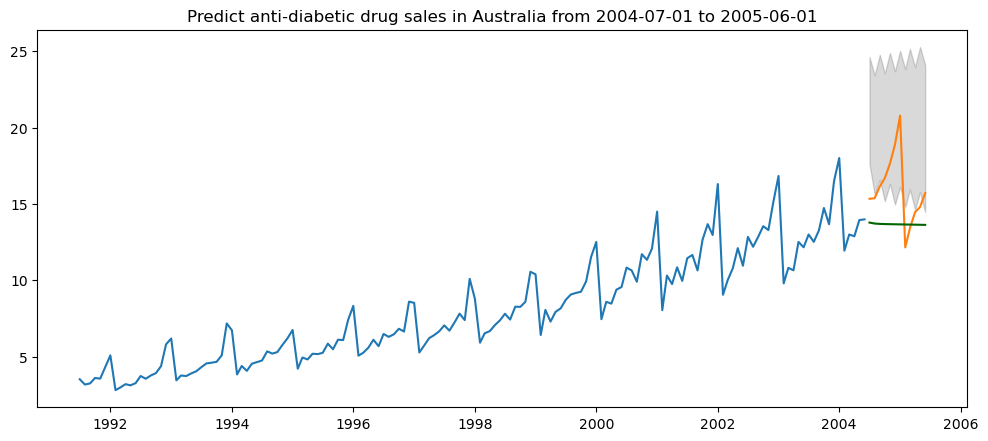

In [45]:
# make series for plotting purpose
fc_series_auto_nonseasonal1 = pd.Series(fc_auto_nonseasonal1, index=test_data1.index)
lower_series = pd.Series(confint[:, 0], index=test_data1.index)
upper_series = pd.Series(confint[:, 1], index=test_data1.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data1, label='train')
plt.plot(test_data1, label='test')
plt.plot(fc_series_auto_nonseasonal1, color='darkgreen', label='forecast')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.title('Predict anti-diabetic drug sales in Australia from {} to {}'.format('2004-07-01', '2005-06-01'))
plt.show()

In [46]:
fc_series_auto_nonseasonal2 = pd.Series(fc_auto_nonseasonal2, index=test_data2.index)
fc_series_auto_nonseasonal3 = pd.Series(fc_auto_nonseasonal3, index=test_data3.index)
fc_series_auto_nonseasonal4 = pd.Series(fc_auto_nonseasonal4, index=test_data4.index)

## Auto ARIMA Seasonal 

In [47]:
# Seasonal - fit stepwise auto-ARIMA
smodel_1 = pm.auto_arima ( train_data1, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
print("Model 1 Summary:")
smodel_1.summary()



smodel_2 = pm.auto_arima ( train_data2, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
print("Model 2 Summary:")
smodel_2.summary()


smodel_3 = pm.auto_arima ( train_data3, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
print("Model 3 Summary:")
smodel_3.summary()


smodel_4 = pm.auto_arima ( train_data4, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
print("Model 4 Summary:")
smodel_4.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=226.709, Time=0.19 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=310.796, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=260.993, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=227.309, Time=0.12 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=229.668, Time=0.09 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=225.508, Time=0.33 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=228.659, Time=0.12 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=225.817, Time=0.70 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=226.347, Time=1.02 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=224.365, Time=0.48 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=224.161, Time=0.50 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=225.964, Time=0.83 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=225.121, Time=0.41 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=306.412, Time=0.42 sec
 ARIMA(0,1,2)(0,1,2)[12]         

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  192
Model:             SARIMAX(3, 1, 2)x(1, 1, 2, 12)   Log Likelihood                -199.854
Date:                            Thu, 17 Nov 2022   AIC                            417.708
Time:                                    11:48:02   BIC                            446.395
Sample:                                07-01-1991   HQIC                           429.341
                                     - 06-01-2007                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5684      0.199     -2.853      0.004      -0.959      -0.178
ar.L2          0.3586      0.130      2.761      0.006       0.104       0.613
ar.L3          0.3405      0.077      4.417      0.000       0.189       0.492
ma.L1         -0.2248      0.231     -0.974      0.330      -0.677       0.227
ma.L2         -0.6161      0.171     -3.609      0.000      -0.951      -0.282
ar.S.L12      -0.5863      0.357     -1.643      0.100      -1.286       0.113
ma.S.L12       0.4532      0.353      1.284      0.199      -0.239       1.145
ma.S.L24      -0.2938      0.103     -2.852      0.004      -0.496      -0.092
sigma2         0.5347      0.042     12.711      0.000       0.452       0.617
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               161.12
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               8.91   Skew:                             0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
# Forecast
n_periods = 12
fc_auto_seasonal_1, confint = smodel_1.predict(n_periods=n_periods, return_conf_int=True)
fc_auto_seasonal_2, confint = smodel_2.predict(n_periods=n_periods, return_conf_int=True)
fc_auto_seasonal_3, confint = smodel_3.predict(n_periods=n_periods, return_conf_int=True)
fc_auto_seasonal_4, confint = smodel_4.predict(n_periods=n_periods, return_conf_int=True)


In [49]:
fc_auto_seasonal_1

2004-07-01    14.511730
2004-08-01    14.178499
2004-09-01    14.609972
2004-10-01    16.099156
2004-11-01    15.424345
2004-12-01    17.652314
2005-01-01    19.364367
2005-02-01    13.253873
2005-03-01    14.329019
2005-04-01    14.331793
2005-05-01    15.389403
2005-06-01    15.255920
Freq: MS, dtype: float64

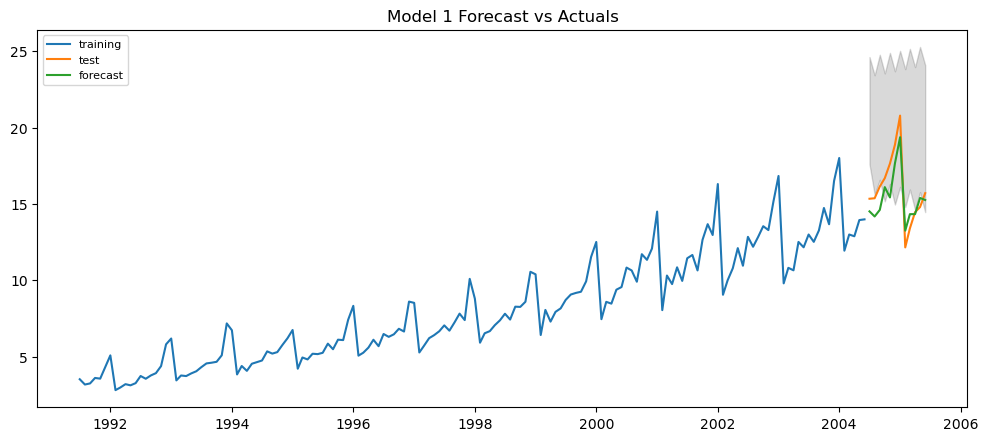

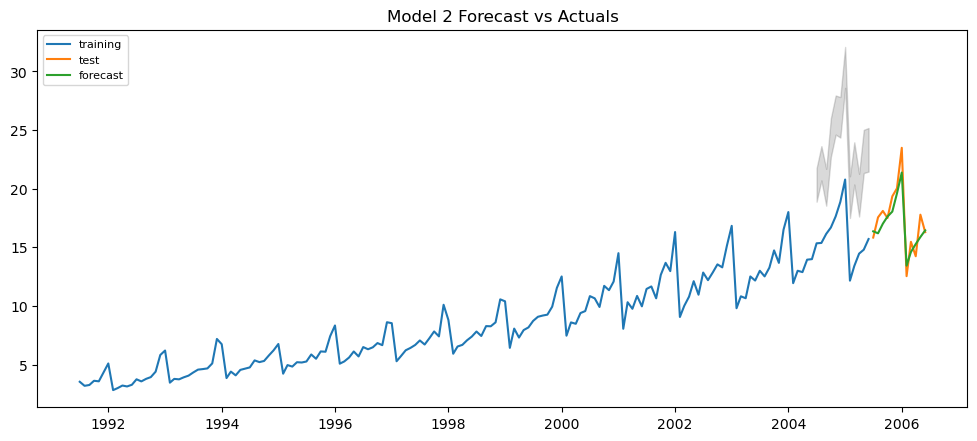

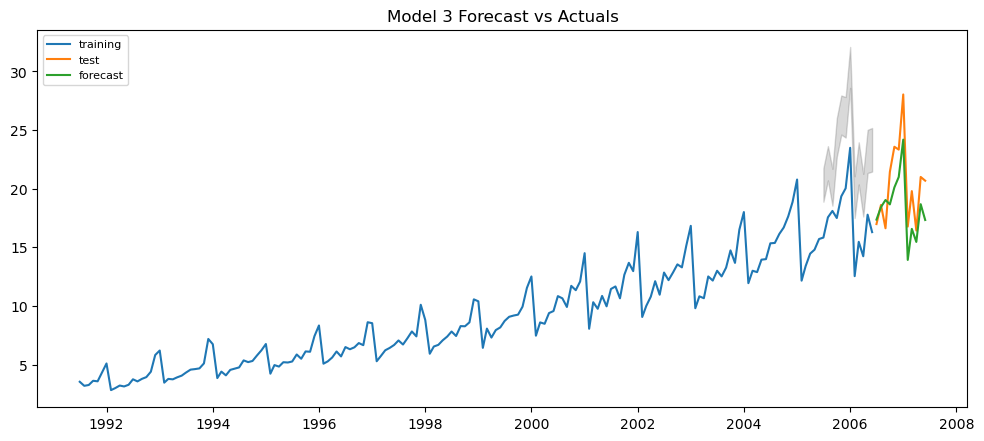

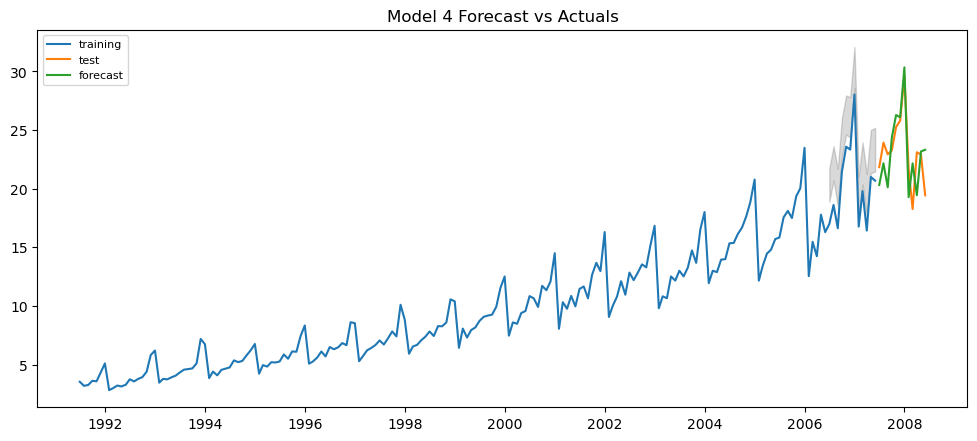

In [50]:
# make series for plotting purpose
fc_series_auto_seasonal_1 = pd.Series(fc_auto_seasonal_1, index=test_data1.index)
lower_series1 = pd.Series(confint[:, 0], index=test_data1.index)
upper_series1 = pd.Series(confint[:, 1], index=test_data1.index)

fc_series_auto_seasonal_2 = pd.Series(fc_auto_seasonal_2, index=test_data2.index)
lower_series2 = pd.Series(confint[:, 0], index=test_data2.index)
upper_series2 = pd.Series(confint[:, 1], index=test_data2.index)

fc_series_auto_seasonal_3 = pd.Series(fc_auto_seasonal_3, index=test_data3.index)
lower_series3 = pd.Series(confint[:, 0], index=test_data3.index)
upper_series3 = pd.Series(confint[:, 1], index=test_data3.index)

fc_series_auto_seasonal_4 = pd.Series(fc_auto_seasonal_4, index=test_data4.index)
lower_series4 = pd.Series(confint[:, 0], index=test_data4.index)
upper_series4 = pd.Series(confint[:, 1], index=test_data4.index)
# Plot1
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data1, label='training')
plt.plot(test_data1, label='test')
plt.plot(fc_series_auto_seasonal_1, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Model 1 Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()
fc_series_auto_seasonal_1 = pd.Series(fc_auto_seasonal_1, index=test_data1.index)
lower_series = pd.Series(confint[:, 0], index=test_data1.index)
upper_series = pd.Series(confint[:, 1], index=test_data1.index)

# Plot2
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data2, label='training')
plt.plot(test_data2, label='test')
plt.plot(fc_series_auto_seasonal_2, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Model 2 Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()
fc_series_auto_seasonal_2 = pd.Series(fc_auto_seasonal_2, index=test_data2.index)
lower_series = pd.Series(confint[:, 0], index=test_data2.index)
upper_series = pd.Series(confint[:, 1], index=test_data2.index)

# Plot3
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data3, label='training')
plt.plot(test_data3, label='test')
plt.plot(fc_series_auto_seasonal_3, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Model 3 Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()
fc_series_auto_seasonal_3 = pd.Series(fc_auto_seasonal_3, index=test_data3.index)
lower_series = pd.Series(confint[:, 0], index=test_data3.index)
upper_series = pd.Series(confint[:, 1], index=test_data3.index)

# Plot4
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data4, label='training')
plt.plot(test_data4, label='test')
plt.plot(fc_series_auto_seasonal_4, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Model 4 Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Model Evaluation

In [51]:
#define metrics dataframe which will be used below for 
metrics_dataframe = pd.DataFrame(columns=['Model', 'RMSE', 'MAE', 'MAPE'])

                                 
def metrics_cal(actuals, predictions, model):
    mse = mean_squared_error(actuals, predictions)
    rmse = sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    
    df = pd.DataFrame({'Model': model,
                       'RMSE': rmse,
                       'MAE': mae, 
                       'MAPE': mape}, index=[0])
    dataframe = metrics_dataframe.append(df)
    return dataframe

In [52]:
fc_series1

date
2004-07-01    13.808858
2004-08-01    13.757604
2004-09-01    13.743060
2004-10-01    13.738933
2004-11-01    13.737761
2004-12-01    13.737429
2005-01-01    13.737335
2005-02-01    13.737308
2005-03-01    13.737300
2005-04-01    13.737298
2005-05-01    13.737298
2005-06-01    13.737297
Name: predicted_mean, dtype: float64

In [53]:
metrics_dataframe = metrics_dataframe.iloc[0:0]

In [54]:
#get all the metrics
metrics_dataframe = metrics_cal(test_data1.values.flatten(), 
                                 fc_series1.values.flatten(), 
                                 'Manual ARIMA 1')

metrics_dataframe = metrics_cal(test_data1.values.flatten(), 
                                 fc_series_auto_nonseasonal1.values.flatten(), 
                                 'Auto ARIMA Non Seasonal 1')

metrics_dataframe = metrics_cal(test_data1.values.flatten(), 
                                fc_series_auto_seasonal_1.values.flatten(), 
                                'Auto ARIMA Seasonal 1')


metrics_dataframe = metrics_cal(test_data2.values.flatten(), 
                                fc_series2.values.flatten(), 
                                'Manual ARIMA 2')

metrics_dataframe = metrics_cal(test_data2.values.flatten(), 
                                fc_series_auto_nonseasonal2.values.flatten(), 
                                'Auto ARIMA Non Seasonal 2')

metrics_dataframe = metrics_cal(test_data2.values.flatten(), 
                                fc_series_auto_seasonal_2.values.flatten(), 
                                'Auto ARIMA Seasonal 2')



metrics_dataframe = metrics_cal(test_data3.values.flatten(), 
                                fc_series3.values.flatten(), 
                                'Manual ARIMA 3')

metrics_dataframe = metrics_cal(test_data3.values.flatten(), 
                                fc_series_auto_nonseasonal3.values.flatten(), 
                                'Auto ARIMA Non Seasonal 3')

metrics_dataframe = metrics_cal(test_data3.values.flatten(), 
                                fc_series_auto_seasonal_3.values.flatten(), 
                                'Auto ARIMA Seasonal 3')


metrics_dataframe = metrics_cal(test_data4.values.flatten(), 
                                fc_series4.values.flatten(), 
                                'Manual ARIMA 4')

metrics_dataframe = metrics_cal(test_data4.values.flatten(), 
                                fc_series_auto_nonseasonal4.values.flatten(), 
                                'Auto ARIMA Non Seasonal 4')

metrics_dataframe = metrics_cal(test_data4.values.flatten(), 
                                fc_series_auto_seasonal_4.values.flatten(), 
                                'Auto ARIMA Seasonal 4')

In [55]:
metrics_dataframe

,Model,RMSE,MAE,MAPE
0,Manual ARIMA 1,3.144205,2.518898,14.698236
0,Auto ARIMA Non Seasonal 1,3.192067,2.562634,14.941777
0,Auto ARIMA Seasonal 1,1.147893,1.014920,6.306285
0,Manual ARIMA 2,3.369213,2.627344,14.216096
0,Auto ARIMA Non Seasonal 2,3.413987,2.675261,14.452220
0,Auto ARIMA Seasonal 2,1.154636,0.985713,5.626409
0,Manual ARIMA 3,4.918128,3.642289,15.894465
0,Auto ARIMA Non Seasonal 3,4.879762,3.747040,16.579521
0,Auto ARIMA Seasonal 3,2.615164,2.343005,11.295691
0,Manual ARIMA 4,4.265082,3.554504,14.463060


In [56]:
metrics_df = metrics_dataframe.set_index('Model')

In [57]:
metrics_df

,RMSE,MAE,MAPE
Model,,,
Manual ARIMA 1,3.144205,2.518898,14.698236
Auto ARIMA Non Seasonal 1,3.192067,2.562634,14.941777
Auto ARIMA Seasonal 1,1.147893,1.014920,6.306285
Manual ARIMA 2,3.369213,2.627344,14.216096
Auto ARIMA Non Seasonal 2,3.413987,2.675261,14.452220
Auto ARIMA Seasonal 2,1.154636,0.985713,5.626409
Manual ARIMA 3,4.918128,3.642289,15.894465
Auto ARIMA Non Seasonal 3,4.879762,3.747040,16.579521
Auto ARIMA Seasonal 3,2.615164,2.343005,11.295691


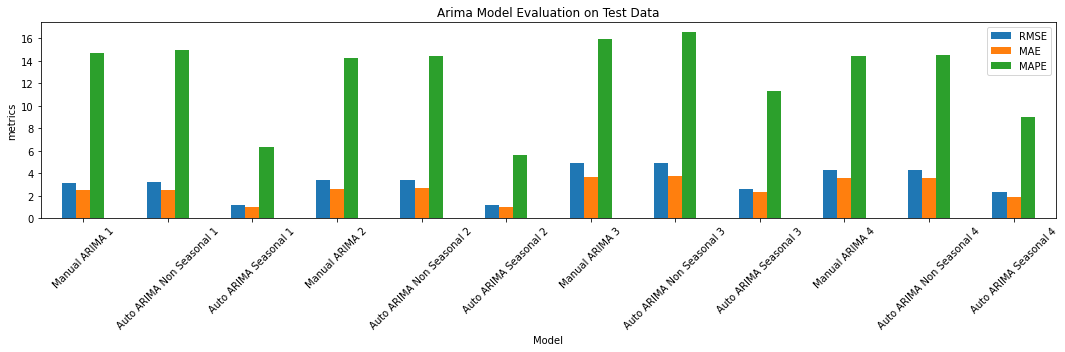

In [58]:
# to set the plot size
%matplotlib inline  
metrics_df \
         .plot(kind = "bar", stacked = False, figsize = (15,5), rot = 0) \
         .set(xlabel = "Model",
              ylabel = ['RMSE', 'MAE', 'MAPE'],
              title = "Arima Model Evaluation on Test Data")
# adding legend to the curve
plt.legend()
plt.ylabel('metrics')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

## Findings
### Auto ARIMA Seasonal Model works best for all 4 test data sets, with the lowest values for all the metrics. 

In [59]:
# Create a data frame with all the predictions along with the test data
test_pred_df1 = test_data1.copy()

# Add all predictions 
test_pred_df1 = test_pred_df1.assign(manual_arima_pred_1 = fc_series1.values.flatten(),
                                     auto_nonseasonal_pred_1= fc_series_auto_nonseasonal1.values.flatten(),
                                     auto_seasonal_pred_1 = fc_series_auto_seasonal_1.values.flatten(),
                                     avg_pred_1 = (fc_series1.values.flatten()+
                                                   fc_series_auto_nonseasonal1.values.flatten()+
                                                   fc_series_auto_seasonal_1.values.flatten())/3)

test_pred_df2 = test_data2.copy()

# Add all predictions 
test_pred_df2 = test_pred_df2.assign(manual_arima_pred_2 = fc_series2.values.flatten(),
                                     auto_nonseasonal_pred_2 = fc_series_auto_nonseasonal2.values.flatten(),
                                     auto_seasonal_pred_2 = fc_series_auto_seasonal_2.values.flatten(),
                                     avg_pred_2 = (fc_series2.values.flatten()+
                                                   fc_series_auto_nonseasonal2.values.flatten()+
                                                   fc_series_auto_seasonal_2.values.flatten())/3)


test_pred_df3 = test_data3.copy()

# Add all predictions 
test_pred_df3 = test_pred_df3.assign(manual_arima_pred_3 = fc_series3.values.flatten(),
                                     auto_nonseasonal_pred_3 = fc_series_auto_nonseasonal3.values.flatten(),
                                     auto_seasonal_pred_3 = fc_series_auto_seasonal_3.values.flatten(),
                                     avg_pred_3 = (fc_series3.values.flatten()+
                                                   fc_series_auto_nonseasonal3.values.flatten()+
                                                   fc_series_auto_seasonal_3.values.flatten())/3)


test_pred_df4 = test_data4.copy()

# Add all predictions 
test_pred_df4 = test_pred_df4.assign(manual_arima_pred_4 = fc_series2.values.flatten(),
                                     auto_nonseasonal_pred_4 = fc_series_auto_nonseasonal4.values.flatten(),
                                     auto_seasonal_pred_4 = fc_series_auto_seasonal_4.values.flatten(),
                                     avg_pred_4 = (fc_series4.values.flatten()+
                                                   fc_series_auto_nonseasonal4.values.flatten()+
                                                   fc_series_auto_seasonal_4.values.flatten())/3)

In [60]:
test_pred_df1

,value,manual_arima_pred_1,auto_nonseasonal_pred_1,auto_seasonal_pred_1,avg_pred_1
date,,,,,
2004-07-01,15.339097,13.808858,13.779698,14.511730,14.033429
2004-08-01,15.370764,13.757604,13.715521,14.178499,13.883875
2004-09-01,16.142005,13.743060,13.692685,14.609972,14.015239
2004-10-01,16.685754,13.738933,13.681590,16.099156,14.506559
2004-11-01,17.636728,13.737761,13.673829,15.424345,14.278645
2004-12-01,18.869325,13.737429,13.667019,17.652314,15.018920
2005-01-01,20.778723,13.737335,13.660479,19.364367,15.587394
2005-02-01,12.154552,13.737308,13.654020,13.253873,13.548400
2005-03-01,13.402392,13.737300,13.647584,14.329019,13.904635


<Figure size 2400x1200 with 0 Axes>

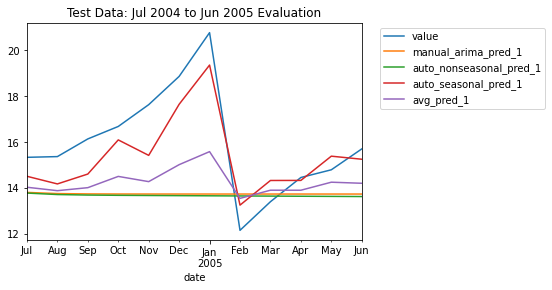

In [61]:
plt.figure(figsize=(16, 8), dpi=150)
test_pred_df1.plot()
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title("Test Data: Jul 2004 to Jun 2005 Evaluation")
plt.show()

<Figure size 2400x1200 with 0 Axes>

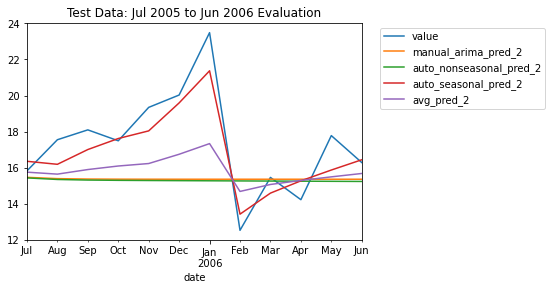

In [62]:
plt.figure(figsize=(16, 8), dpi=150)
test_pred_df2.plot()
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title("Test Data: Jul 2005 to Jun 2006 Evaluation")
plt.show()

<Figure size 2400x1200 with 0 Axes>

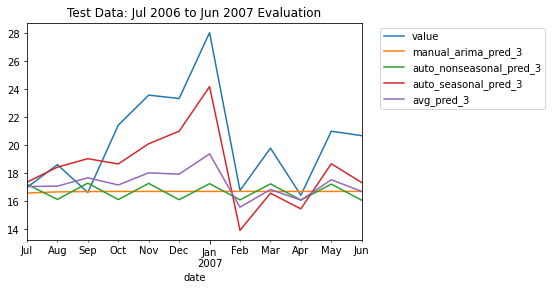

In [63]:
plt.figure(figsize=(16, 8), dpi=150)
test_pred_df3.plot()
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title("Test Data: Jul 2006 to Jun 2007 Evaluation")
plt.show()

<Figure size 2400x1200 with 0 Axes>

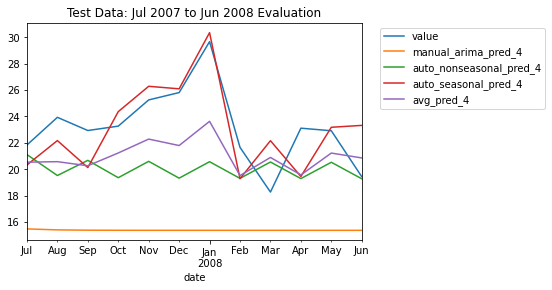

In [64]:
plt.figure(figsize=(16, 8), dpi=150)
test_pred_df4.plot()
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title("Test Data: Jul 2007 to Jun 2008 Evaluation")
plt.show()

# ETS - Error, Trend and Seasonality

## Simple Exponential Smoothing

In [65]:
ins1 = SimpleExpSmoothing(train_data1).fit()
ins_cast1 = ins1.forecast(12).rename('alpha=%s'%ins1.model.params['smoothing_level'])

ins2 = SimpleExpSmoothing(train_data2).fit()
ins_cast2 = ins2.forecast(12).rename('alpha=%s'%ins2.model.params['smoothing_level'])

ins3 = SimpleExpSmoothing(train_data3).fit()
ins_cast3 = ins3.forecast(12).rename('alpha=%s'%ins3.model.params['smoothing_level'])

ins4 = SimpleExpSmoothing(train_data4).fit()
ins_cast4 = ins4.forecast(12).rename('alpha=%s'%ins4.model.params['smoothing_level'])

C:\Users\frede\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\frede\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\frede\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\frede\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## Double Exponential Smoothing

In [66]:
double_ets_add1 = ExponentialSmoothing(train_data1, trend = 'add').fit()
double_ets_mul1 = ExponentialSmoothing(train_data1, trend = 'mul').fit()

double_ets_add_pred1 = double_ets_add1.forecast(12)
double_ets_mul_pred1= double_ets_mul1.forecast(12)

########################################################################################
double_ets_add2 = ExponentialSmoothing(train_data2, trend = 'add').fit()
double_ets_mul2 = ExponentialSmoothing(train_data2, trend = 'mul').fit()

double_ets_add_pred2 = double_ets_add2.forecast(12)
double_ets_mul_pred2= double_ets_mul2.forecast(12)
#########################################################################################

double_ets_add3 = ExponentialSmoothing(train_data3, trend = 'add').fit()
double_ets_mul3 = ExponentialSmoothing(train_data3, trend = 'mul').fit()

double_ets_add_pred3 = double_ets_add3.forecast(12)
double_ets_mul_pred3= double_ets_mul3.forecast(12)
#########################################################################################

double_ets_add4 = ExponentialSmoothing(train_data4, trend = 'add').fit()
double_ets_mul4 = ExponentialSmoothing(train_data4, trend = 'mul').fit()

double_ets_add_pred4 = double_ets_add4.forecast(12)
double_ets_mul_pred4 = double_ets_mul4.forecast(12)


C:\Users\frede\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\frede\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\frede\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\frede\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\frede\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\frede\anaconda3

## Triple Exponential Smoothing

In [67]:
triple_ets_add1 = ExponentialSmoothing(train_data1, trend = 'add', seasonal = 'add', seasonal_periods=12).fit()
triple_ets_mul1 = ExponentialSmoothing(train_data1, trend = 'mul', seasonal = 'mul', seasonal_periods=12).fit()

triple_ets_add_pred1 = triple_ets_add1.forecast(12)
triple_ets_mul_pred1 = triple_ets_mul1.forecast(12)
########################################################################################
triple_ets_add2 = ExponentialSmoothing(train_data2, trend = 'add', seasonal = 'add', seasonal_periods=12).fit()
triple_ets_mul2 = ExponentialSmoothing(train_data2, trend = 'mul', seasonal = 'mul', seasonal_periods=12).fit()

triple_ets_add_pred2 = triple_ets_add2.forecast(12)
triple_ets_mul_pred2 = triple_ets_mul2.forecast(12)
########################################################################################
triple_ets_add3 = ExponentialSmoothing(train_data3, trend = 'add', seasonal = 'add', seasonal_periods=12).fit()
triple_ets_mul3 = ExponentialSmoothing(train_data3, trend = 'mul', seasonal = 'mul', seasonal_periods=12).fit()

triple_ets_add_pred3 = triple_ets_add3.forecast(12)
triple_ets_mul_pred3 = triple_ets_mul3.forecast(12)
########################################################################################
triple_ets_add4 = ExponentialSmoothing(train_data4, trend = 'add', seasonal = 'add', seasonal_periods=12).fit()
triple_ets_mul4 = ExponentialSmoothing(train_data4, trend = 'mul', seasonal = 'mul', seasonal_periods=12).fit()

triple_ets_add_pred4 = triple_ets_add4.forecast(12)
triple_ets_mul_pred4 = triple_ets_mul4.forecast(12)

C:\Users\frede\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\frede\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\frede\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\frede\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\frede\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

### ETS - Model Evaluation

In [68]:
#define metrics dataframe which will be used below for 
evaulation_metrics = pd.DataFrame(columns=['Model', 'RMSE', 'MAE', 'MAPE'])

                                 
def eva_metrics_cal(actuals, predictions, model):
    mse = mean_squared_error(actuals, predictions)
    rmse = sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    wmape = sum(np.abs(actuals - predictions))/sum(actuals)
    df = pd.DataFrame({'Model': model,
                       'MSE': mse,
                       'RMSE': rmse,
                       'MAE': mae, 
                       'MAPE': mape,
                       'WMAPE' : wmape}, index=[0])
    dataframe = evaulation_metrics.append(df)
    return dataframe

In [69]:
evaulation_metrics = evaulation_metrics.iloc[0:0]

In [70]:
evaulation_metrics

,Model,RMSE,MAE,MAPE


In [71]:

evaulation_metrics = eva_metrics_cal(test_data1.values.flatten(), 
                                ins_cast1.values.flatten(), 
                                'Simple 1')
evaulation_metrics = eva_metrics_cal(test_data2.values.flatten(), 
                                ins_cast2.values.flatten(), 
                                'Simple 2')
evaulation_metrics = eva_metrics_cal(test_data3.values.flatten(), 
                                ins_cast3.values.flatten(), 
                                'Simple 3')
evaulation_metrics = eva_metrics_cal(test_data4.values.flatten(), 
                                ins_cast4.values.flatten(), 
                                'Simple 4')
#######################################################################################################################
evaulation_metrics = eva_metrics_cal(test_data1.values.flatten(), 
                                double_ets_add_pred1.values.flatten(), 
                                'Double Add 1')
evaulation_metrics = eva_metrics_cal(test_data1.values.flatten(), 
                                double_ets_mul_pred1.values.flatten(), 
                                'Double Mul 1')
evaulation_metrics = eva_metrics_cal(test_data2.values.flatten(), 
                                double_ets_add_pred2.values.flatten(), 
                                'Double Add 2')
evaulation_metrics = eva_metrics_cal(test_data2.values.flatten(), 
                                double_ets_mul_pred2.values.flatten(), 
                                'Double Mul 2')
evaulation_metrics = eva_metrics_cal(test_data3.values.flatten(), 
                                double_ets_add_pred3.values.flatten(), 
                                'Double Add 3')
evaulation_metrics = eva_metrics_cal(test_data3.values.flatten(), 
                                double_ets_mul_pred3.values.flatten(), 
                                'Double Mul 3')
evaulation_metrics = eva_metrics_cal(test_data4.values.flatten(), 
                                double_ets_add_pred4.values.flatten(), 
                                'Double Add 4')
evaulation_metrics = eva_metrics_cal(test_data4.values.flatten(), 
                                double_ets_mul_pred4.values.flatten(), 
                                'Double Mul 4')
#######################################################################################################################
evaulation_metrics = eva_metrics_cal(test_data1.values.flatten(), 
                                triple_ets_add_pred1.values.flatten(), 
                                'Triple Add 1')
evaulation_metrics = eva_metrics_cal(test_data1.values.flatten(), 
                                triple_ets_mul_pred1.values.flatten(), 
                                'Triple Mul 1')
evaulation_metrics = eva_metrics_cal(test_data2.values.flatten(), 
                                triple_ets_add_pred2.values.flatten(), 
                                'Triple Add 2')
evaulation_metrics = eva_metrics_cal(test_data2.values.flatten(), 
                                triple_ets_mul_pred2.values.flatten(), 
                                'Triple Mul 2')
evaulation_metrics = eva_metrics_cal(test_data3.values.flatten(), 
                                triple_ets_add_pred3.values.flatten(), 
                                'Triple Add 3')
evaulation_metrics = eva_metrics_cal(test_data3.values.flatten(), 
                                triple_ets_mul_pred3.values.flatten(), 
                                'Triple Mul 3')
evaulation_metrics = eva_metrics_cal(test_data4.values.flatten(), 
                                triple_ets_add_pred4.values.flatten(), 
                                'Triple Add 4')
evaulation_metrics = eva_metrics_cal(test_data4.values.flatten(), 
                                triple_ets_mul_pred4.values.flatten(), 
                                'Triple Mul 4')

In [72]:
ETS_evaulation_metrics=evaulation_metrics.set_index(['Model'])

In [73]:
ETS_evaulation_metrics

,RMSE,MAE,MAPE,MSE,WMAPE
Model,,,,,
Simple 1,3.096006,2.476754,14.466114,9.585254,0.155332
Simple 2,3.432111,2.706162,14.631779,11.779386,0.156005
Simple 3,4.966458,3.676396,16.036388,24.665701,0.181356
Simple 4,4.139542,3.453205,14.079696,17.135812,0.149032
Double Add 1,2.532282,1.999902,12.092792,6.412453,0.125426
Double Mul 1,2.411873,1.961102,12.448460,5.817133,0.122992
Double Add 2,2.902854,2.303359,13.254271,8.426564,0.132784
Double Mul 2,2.916418,2.309959,13.994911,8.505495,0.133165
Double Add 3,3.840684,2.931650,13.278898,14.750852,0.144618


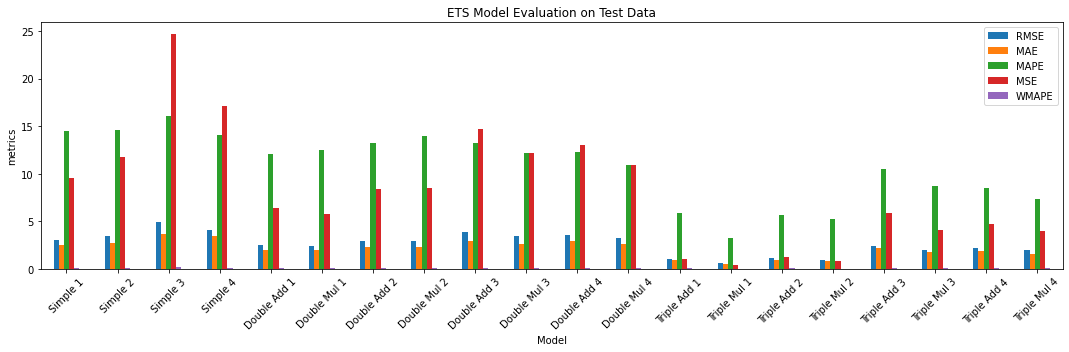

In [74]:

ETS_evaulation_metrics \
         .plot(kind = "bar", stacked = False, figsize = (15,5), rot = 0) \
         .set(xlabel = "Model",
              ylabel = ['RMSE', 'MAE', 'MAPE', 'MSE', 'WMAPE'],
              title = "ETS Model Evaluation on Test Data")
# adding legend to the curve
plt.legend()
plt.ylabel('metrics')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

### Create a data frame with all the predictions along with the test data

In [75]:
test_pred_df1 = test_data1.copy()

# Add all predictions 
test_pred_df1 = test_pred_df1.assign(SimpleExp_1_pred = ins_cast1.values.flatten(),
                                     Double_add_pred1 = double_ets_add_pred1.values.flatten(),
                                     Double_mul_pred1 = double_ets_mul_pred1.values.flatten(),
                                     Triple_add_pred1 = triple_ets_add_pred1.values.flatten(),
                                     Triple_mul_pred1 = triple_ets_mul_pred1.values.flatten())

test_pred_df1

,value,SimpleExp_1_pred,Double_add_pred1,Double_mul_pred1,Triple_add_pred1,Triple_mul_pred1
date,,,,,,
2004-07-01,15.339097,13.812999,14.474817,15.117479,14.656420,15.081055
2004-08-01,15.370764,13.812999,14.565684,15.253854,14.259362,14.883018
2004-09-01,16.142005,13.812999,14.656550,15.391458,14.961024,15.051097
2004-10-01,16.685754,13.812999,14.747417,15.530304,16.299622,16.427136
2004-11-01,17.636728,13.812999,14.838283,15.670403,15.496982,16.440641
2004-12-01,18.869325,13.812999,14.929150,15.811765,18.007873,18.906363
2005-01-01,20.778723,13.812999,15.020016,15.954403,19.552880,20.774158
2005-02-01,12.154552,13.812999,15.110883,16.098327,13.209524,12.483367
2005-03-01,13.402392,13.812999,15.201750,16.243550,14.170720,14.156611


<Figure size 2400x1200 with 0 Axes>

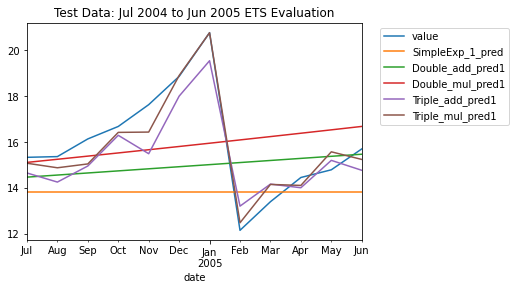

In [76]:
plt.figure(figsize=(16, 8), dpi=150)
test_pred_df1.plot()
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title("Test Data: Jul 2004 to Jun 2005 ETS Evaluation")
plt.show()

In [77]:
test_pred_df2 = test_data2.copy()

# Add all predictions 
test_pred_df2 = test_pred_df2.assign(SimpleExp_2_pred = ins_cast2.values.flatten(),
                                     Double_add_pred2 = double_ets_add_pred2.values.flatten(),
                                     Double_mul_pred2 = double_ets_mul_pred2.values.flatten(),
                                     Triple_add_pred2 = triple_ets_add_pred2.values.flatten(),
                                     Triple_mul_pred2 = triple_ets_mul_pred2.values.flatten())

test_pred_df2

,value,SimpleExp_2_pred,Double_add_pred2,Double_mul_pred2,Triple_add_pred2,Triple_mul_pred2
date,,,,,,
2005-07-01,15.829550,15.26803,16.116214,16.825423,16.599272,16.839776
2005-08-01,17.554701,15.26803,16.223938,16.976842,16.427608,16.671400
2005-09-01,18.100864,15.26803,16.331662,17.129625,17.046711,16.995259
2005-10-01,17.496668,15.26803,16.439386,17.283782,17.768447,18.338158
2005-11-01,19.347265,15.26803,16.547110,17.439327,18.113053,18.569077
2005-12-01,20.031291,15.26803,16.654834,17.596272,19.553103,21.028932
2006-01-01,23.486694,15.26803,16.762558,17.754628,21.300443,23.117378
2006-02-01,12.536987,15.26803,16.870282,17.914411,13.427192,13.814008
2006-03-01,15.467018,15.26803,16.978006,18.075631,14.790311,15.582779


<Figure size 2400x1200 with 0 Axes>

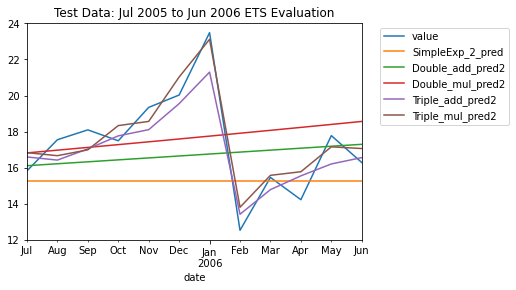

In [78]:
plt.figure(figsize=(16, 8), dpi=150)
test_pred_df2.plot()
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title("Test Data: Jul 2005 to Jun 2006 ETS Evaluation")
plt.show()

In [79]:
test_pred_df3 = test_data3.copy()

# Add all predictions 
test_pred_df3 = test_pred_df3.assign(SimpleExp_3_pred = ins_cast3.values.flatten(),
                                     Double_add_pred3 = double_ets_add_pred3.values.flatten(),
                                     Double_mul_pred3 = double_ets_mul_pred3.values.flatten(),
                                     Triple_add_pred3 = triple_ets_add_pred3.values.flatten(),
                                     Triple_mul_pred3 = triple_ets_mul_pred3.values.flatten())


<Figure size 2400x1200 with 0 Axes>

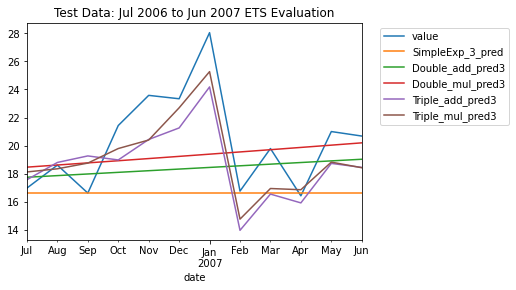

In [80]:
plt.figure(figsize=(16, 8), dpi=150)
test_pred_df3.plot()
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title("Test Data: Jul 2006 to Jun 2007 ETS Evaluation")
plt.show()

In [81]:
test_pred_df4 = test_data4.copy()

# Add all predictions 
test_pred_df4 = test_pred_df4.assign(SimpleExp_4_pred = ins_cast4.values.flatten(),
                                     Double_add_pred4 = double_ets_add_pred4.values.flatten(),
                                     Double_mul_pred4 = double_ets_mul_pred4.values.flatten(),
                                     Triple_add_pred4 = triple_ets_add_pred4.values.flatten(),
                                     Triple_mul_pred4 = triple_ets_mul_pred4.values.flatten())

test_pred_df4

,value,SimpleExp_4_pred,Double_add_pred4,Double_mul_pred4,Triple_add_pred4,Triple_mul_pred4
date,,,,,,
2007-07-01,21.834890,20.152449,20.350267,20.970734,20.882426,21.491803
2007-08-01,23.930204,20.152449,20.511013,21.160638,22.592323,22.070226
2007-09-01,22.930357,20.152449,20.671760,21.352260,21.388972,22.041933
2007-10-01,23.263340,20.152449,20.832507,21.545618,25.178576,24.088621
2007-11-01,25.250030,20.152449,20.993254,21.740727,26.776456,25.176790
2007-12-01,25.806090,20.152449,21.154000,21.937603,26.424242,27.361714
2008-01-01,29.665356,20.152449,21.314747,22.136262,30.468346,30.940574
2008-02-01,21.654285,20.152449,21.475494,22.336720,19.065217,18.181453
2008-03-01,18.264945,20.152449,21.636241,22.538993,21.834332,21.004155


<Figure size 2400x1200 with 0 Axes>

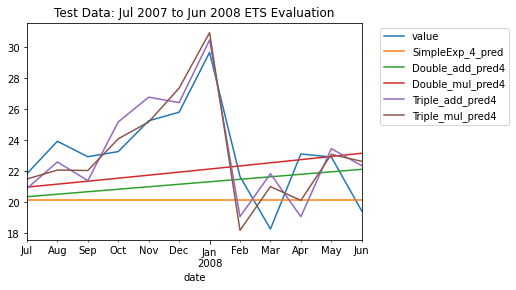

In [82]:
plt.figure(figsize=(16, 8), dpi=150)
test_pred_df4.plot()
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title("Test Data: Jul 2007 to Jun 2008 ETS Evaluation")
plt.show()

## Time Series Cross Validation - see slides

Sources: 

https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4

https://towardsdatascience.com/dont-use-k-fold-validation-for-time-series-forecasting-30b724aaea64